# Face Recognition With Deep Learning

Rico Steinke, 196949, Heilbronn University, rsteinke@stud.hs-heilbronn.de

The project task is to 'create a neural network to recognize your face and clearly discern it from other faces and objects'. Therefore a dataset specifically for this task should be created. Also transfer learning techniques should be used with the restriction that the VGG architecture may not be used. For this purpose, the procedure for creating a data set is shown first. Then, the preprocessing of the data for the use in training a neural network. Finally, the results of the training will be shown and evaluated.
The notebook comes with a file 'condatf.yml' which can be used to create a conda environment that is able to run this notebook. Every cited source is listed in the [Bibliography](#Bibliography) at the end of the notebook.

### Imports
Import the required packages to execute this jupyter notebook.

In [3]:
import datetime
import glob
import os.path
import random
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import shutil
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image

# Data Preparation

### Creating a dataset

- Vorgehen mit OpenCV beschreiben
- Random faces database zitieren <cite id="n544u"><a href="#zotero%7C12668441%2FAN5HZ4B7">(Huang et al., 2007)</a></cite>

#### Constants
First of all a couple of constants are defined to specify the directories which contain the unprocessed image data. Additionally an image size in pixels is defined to compute the images to this size later on. Also the batch size is defined to control how many samples are used in each epoch.

In [4]:
# constants
IMAGES_PATH = "images/"
DATASET_PATH = "dataset/"
DATASET_ME_PATH = DATASET_PATH + "me"
DATASET_SE_PATH = DATASET_PATH + "se"
IMAGES_ME_PATH = IMAGES_PATH + "me"
IMAGES_SE_PATH = IMAGES_PATH + "se"
IMAGES_SE_INPUTPATH = IMAGES_SE_PATH + "/*/*/*"
IMG_SIZE = 192
BATCH_SIZE = 16

To create a dataset to recognize my own face and clearly discern it from other faces it is necessary to get as much pictures of my face as possible. Furthermore different faces are needed. First it is dealt with getting pictures of myself. To achieve this private pictures from my phone and webcam recordings are saved. Secondly OpenCV <cite id="mofvs"><a href="#zotero%7C12668441%2FEXM36PCP">(Bradski, 2000)</a></cite> is used to detect faces in the pictures. This is especially useful to localize a region of interest if the picture contains multiple faces. The cropped images are getting sorted by hand and saved. This step is already done and does not need to be computed to run this notebook.

In [1]:
# make cell not executable
%%script false

# get images from data path
images = [cv.imread(file) for file in glob.glob(f"{IMAGES_PATH}preDetection/*")]
# convert the images to grayscale
images_gray = [cv.cvtColor(image, cv.COLOR_BGR2GRAY) for image in images]
# using cascade classifier for general face detection
cascade = cv.CascadeClassifier(r"files\haarcascade_frontalface_default.xml")
# detect faces
faces = [
    cascade.detectMultiScale(img_gray, scaleFactor=1.3, minNeighbors=5, minSize=(100, 100))
    for img_gray in images_gray
]

# loop over images list
j = 0
k = 0
for i, img in enumerate(images):
    for x, y, width, height in faces[i]:
        # crop image at ROI
        crop_image = img[y : y + height, x : x + width]
        # show image for manual validation
        cv.imshow("cropped image", crop_image)
        cv.waitKey(0)
        cv.destroyAllWindows()
        # ask user to sort image
        print(
            "Press 'm' if the picture shows your face. "
            "Press 's' if the picture shows something or somebody else. "
            "Press 'q' if you don't want to save the picture"
        )
        decision = input()
        if decision == "m":
            saved = cv.imwrite(f"{IMAGES_PATH}me/me_{j}.jpg", crop_image)
            if saved:
                print(f"saved to {IMAGES_PATH}me/me_{j}.jpg")
            j += 1
        elif decision == "s":
            saved = cv.imwrite(f"{IMAGES_SE_PATH}/se_{k}.jpg", crop_image)
            if saved:
                print(f"saved to {IMAGES_SE_PATH}/se_{k}.jpg")
            k += 1

SyntaxError: invalid syntax (2093932259.py, line 1)

# ZELLE UNTEN AKTUALISIEREN

#### Folder structure
The root folder of this project contains the dataset in the *images*-directory and a *preDetection*-directory which contains the private images before labeling them manually as it is described in the step before. The *me*-directory contains images of my face and the *se*-directory contains images of somebody/something else. Those are the directories which are used to create the dataset described in the next step.

**BILD AKTUALISIEREN**

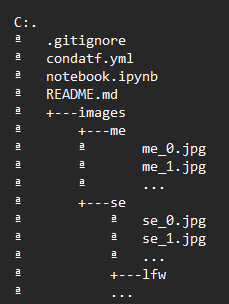

The folder structure used in this project work. Use *'tree /f > tree.txt'* in a shell in your root folder to obtain a graphical view of the folder structure.

#### Create Dataset
To make handling the data easier with tensorflow the *tf.keras.utils.image_dataset_from_directory*-method is used to create a *tf.data.Dataset* from the images in the directories. The creation and visualization of the dataset is done as mentioned in the 'Load and preprocess images'-tutorial of TensorFlow <cite id="8avrg"><a href="#zotero%7C12668441%2FDW3K5WQH">(<i>Load and Preprocess Images | TensorFlow Core</i>, n.d.)</a></cite> and fitted to this use case.

In [9]:
# ask user if a new dataset should be created
userInput = input("If you want to create a new dataset press '1' if not press anything else.")
if userInput == "1":
    createNewDataset = True
else:
    createNewDataset = False

If you want to create a new dataset press '1' if not press anything else. 0


In [11]:
# get random faces database in format for tf dataset creating
# if each subdirectory contains images for a class tf assigns labels automatically

# get amount of pictures of se (https://stackoverflow.com/questions/16910330/return-number-of-files-in-directory-and-subdirectory/16910957)
amountImagesSe = sum([len(files) for r, d, files in os.walk(IMAGES_SE_PATH)])
print(f"Amount of pictures of somebody/something else: {amountImagesSe}")
# get max pictures of me
amountImagesMe = sum([len(files) for r, d, files in os.walk(IMAGES_ME_PATH)])
print(f"Amount of pictures of me: {amountImagesMe}")

# # set ratio of se to me images
# ratioMe = 0.5
# ratioSe = 0.5

# if not ratioMe + ratioSe == 1:
#     print("Error: Sum of ratios has to be 1.")
# elif amountImagesMe < amountImagesSe:

if amountImagesMe < amountImagesSe:
    imageCount = amountImagesMe
else:
    imageCount = amountImagesSe

print("-------------------------------------------------")
print(f"Use {imageCount} images of me and {imageCount} of se to create the dataset. This makes a total of {imageCount + imageCount} images used.")
print("-------------------------------------------------")

if createNewDataset == True:
    # return all path to images in subdirectories from a given root folder
    def load_images_from_folder(rootFolder):
        images = []
        for path, subdirs, files in os.walk(rootFolder):
            for name in files:
                img = os.path.join(path,name)
                if img is not None:
                    images.append(img)
        return images

    imagePathsMe = load_images_from_folder(IMAGES_ME_PATH)
    imagePathsSe = load_images_from_folder(IMAGES_SE_PATH)

    # shuffle image lists randomly
    random.shuffle(imagePathsMe)
    random.shuffle(imagePathsSe)

    # limit amount of images used to create dataset
    imagePathsMe = imagePathsMe[:imageCount]
    imagePathsSe = imagePathsSe[:imageCount]

    # create dataset directory
    if os.path.exists(DATASET_PATH):
        shutil.rmtree(DATASET_PATH)

    os.makedirs(DATASET_ME_PATH) 
    os.makedirs(DATASET_SE_PATH)
    print(f"Created dataset directory at {DATASET_ME_PATH} respectively {DATASET_SE_PATH}")

    # copy random images to dataset directory
    [shutil.copy(image, DATASET_ME_PATH) for image in imagePathsMe]
    [shutil.copy(image, DATASET_SE_PATH) for image in imagePathsSe]


    # create tf datasets
    trainDataset = tf.keras.utils.image_dataset_from_directory(
        DATASET_PATH,
        labels="inferred",
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
    )

    validationDataset = tf.keras.utils.image_dataset_from_directory(
        DATASET_PATH,
        labels="inferred",
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
    )
else:
    print("No new dataset was created.")
    
# print classes for validation of the dataset
classNames = np.array(trainDataset.class_names)
print("-------------------------------------------------")
print(f"The dataset has {classNames.size} classes. Their names are: {classNames}")

Amount of pictures of somebody/something else: 209
Amount of pictures of me: 94
-------------------------------------------------
Use 94 images of me and 94 of se to create the dataset. This makes a total of 188 images used.
-------------------------------------------------
No new dataset was created.
-------------------------------------------------
The dataset has 2 classes. Their names are: ['me' 'se']


#### Have a look at the data

Number of validation batches: 3
Number of test batches: 0


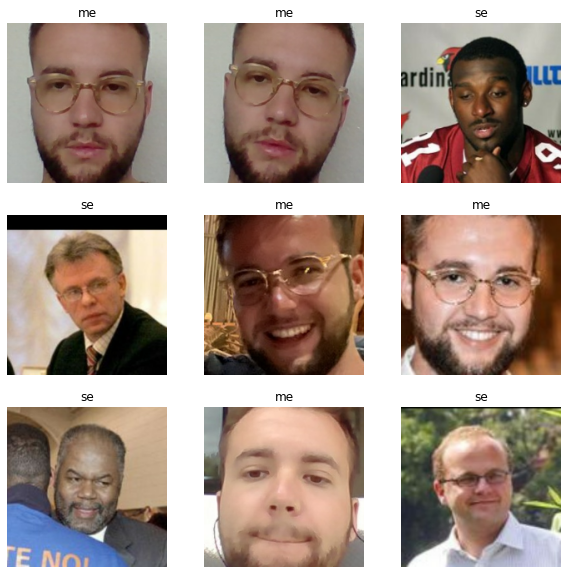

In [46]:
# determine how many batches are available in validation dataset
validationBatches = tf.data.experimental.cardinality(validationDataset)
testDataset = validationDataset.take(validationBatches // 5)
validationDataset = validationDataset.skip(validationBatches // 5)
print("Number of validation batches: %d" % tf.data.experimental.cardinality(validationDataset))
print("Number of test batches: %d" % tf.data.experimental.cardinality(testDataset))

# visualize the data
classNames = trainDataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in trainDataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classNames[labels[i]])
        plt.axis("off")

#### Preprocess the data
- autotune erklären
- standardize erklären
Data augmentation is a technique to increase the diversification of a data set when using a small data set. For this purpose, the training set is transformed randomly but realistically. <cite id="p8s8c"><a href="#zotero%7C12668441%2FK8WZ388C">(<i>Data Augmentation | TensorFlow Core</i>, n.d.)</a></cite>
- quellen

In [6]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
trainDataset = trainDataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validationDataset = validationDataset.cache().prefetch(buffer_size=AUTOTUNE)

# Standardize the data
# get RGB values from [0, 255] range to [0, 1] to have small input values for the neural network
rescaleImagesLayer = layers.Rescaling(1.0 / 255)
# apply rescaling
normalizedDataset = trainDataset.map(lambda x, y: (rescaleImagesLayer(x), y))
imageBatch, labelsBatch = next(iter(normalizedDataset))
# print batch tensor shape for visualization
print(imageBatch.shape)

# apply data augmentation from source:
dataAugmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

(16, 192, 192, 3)


# Network Training

# Evaluation

Grad-CAM class activation visualization

Vergleichen mit OpenCV zugeschnitten

# Discussion of the results

# Bibliography
<!-- BIBLIOGRAPHY START -->
<div class="csl-bib-body">
  <div class="csl-entry"><i id="zotero|12668441/EXM36PCP"></i>Bradski, G. (2000). The OpenCV Library. <i>Dr. Dobb’s Journal of Software Tools</i>.</div>
  <div class="csl-entry"><i id="zotero|12668441/K8WZ388C"></i><i>Data augmentation | TensorFlow Core</i>. (n.d.). TensorFlow. Retrieved June 19, 2022, from <a href="https://www.tensorflow.org/tutorials/images/data_augmentation">https://www.tensorflow.org/tutorials/images/data_augmentation</a></div>
  <div class="csl-entry"><i id="zotero|12668441/AN5HZ4B7"></i>Huang, G. B., Ramesh, M., Berg, T., &#38; Learned-Miller, E. (2007). <i>Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments</i> (No. 07–49). University of Massachusetts, Amherst. <a href="http://vis-www.cs.umass.edu/lfw/index.html">http://vis-www.cs.umass.edu/lfw/index.html</a></div>
  <div class="csl-entry"><i id="zotero|12668441/DW3K5WQH"></i><i>Load and preprocess images | TensorFlow Core</i>. (n.d.). TensorFlow. Retrieved June 19, 2022, from <a href="https://www.tensorflow.org/tutorials/load_data/images">https://www.tensorflow.org/tutorials/load_data/images</a></div>
</div>
<!-- BIBLIOGRAPHY END -->